**Libraries Installed**

In [1]:
!pip install pandas numpy scikit-learn lightgbm shap matplotlib openpyxl

**Loaded  the dataset and done basic cleaning**

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

FILE = "/content/Football Hackathon Upto 2020.csv"
df = pd.read_csv(FILE)
df.columns = df.columns.str.strip()

for c in ['date','Date','match_date']:
    if c in df.columns:
        df['date'] = pd.to_datetime(df[c], errors='coerce')
        break
needed = ['HomeTeam','AwayTeam','FTHG','FTAG']
for col in needed:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
df = df.dropna(subset=['HomeTeam','AwayTeam']).reset_index(drop=True)
print("Loaded rows:", len(df))
df.head(3)

Loaded rows: 5700


,Incremental_ID,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,date
0,1,E0,8/13/2005,NaN,Aston Villa,Bolton,2,2,D,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-13
1,2,E0,8/13/2005,NaN,Everton,Man United,0,2,A,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-13
2,3,E0,8/13/2005,NaN,Fulham,Birmingham,0,0,D,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-13


**Created target result and keeping a clean backup**

In [3]:
if 'FTR' in df.columns:
    df['result'] = df['FTR'].astype(str)
else:
    df['result'] = df.apply(lambda r: 'H' if r['FTHG']>r['FTAG'] else ('A' if r['FTAG']>r['FTHG'] else 'D'), axis=1)

df_clean = df.copy().reset_index(drop=True)
print("Value counts (result):")
print(df_clean['result'].value_counts())

Value counts (result):
result
H    2653
A    1643
D    1404
Name: count, dtype: int64


**we build the bookmaker medians and best odds**

In [4]:
book_prefixes = ['B365','BW','IW','PS','WH','VC']
home_cols = [c for c in df.columns if any(c.startswith(pref) and c.endswith('H') for pref in book_prefixes)]
draw_cols = [c for c in df.columns if any(c.startswith(pref) and c.endswith('D') for pref in book_prefixes)]
away_cols = [c for c in df.columns if any(c.startswith(pref) and c.endswith('A') for pref in book_prefixes)]

for candidate in ['B365H','BWH','IWH','PSH','WHH','VCH']:
    if candidate in df.columns and candidate not in home_cols:
        home_cols.append(candidate)
for candidate in ['B365D','BWD','IWD','PSD','WHD','VCD']:
    if candidate in df.columns and candidate not in draw_cols:
        draw_cols.append(candidate)
for candidate in ['B365A','BWA','IWA','PSA','WHA','VCA']:
    if candidate in df.columns and candidate not in away_cols:
        away_cols.append(candidate)

def safe_median(arr):
    a = [float(x) for x in arr if pd.notna(x) and x>1.01]
    return np.median(a) if len(a)>0 else np.nan

def safe_max(arr):
    a = [float(x) for x in arr if pd.notna(x) and x>1.01]
    return max(a) if len(a)>0 else np.nan

df_clean['odds_home_median'] = df_clean[home_cols].apply(lambda r: safe_median(r.values), axis=1) if home_cols else np.nan
df_clean['odds_draw_median'] = df_clean[draw_cols].apply(lambda r: safe_median(r.values), axis=1) if draw_cols else np.nan
df_clean['odds_away_median'] = df_clean[away_cols].apply(lambda r: safe_median(r.values), axis=1) if away_cols else np.nan

df_clean['odds_home_best'] = df_clean[home_cols].apply(lambda r: safe_max(r.values), axis=1) if home_cols else np.nan
df_clean['odds_draw_best'] = df_clean[draw_cols].apply(lambda r: safe_max(r.values), axis=1) if draw_cols else np.nan
df_clean['odds_away_best'] = df_clean[away_cols].apply(lambda r: safe_max(r.values), axis=1) if away_cols else np.nan

def implied_norm(row):
    p_h = 1.0/row['odds_home_median'] if pd.notna(row['odds_home_median']) else 0.0
    p_d = 1.0/row['odds_draw_median'] if pd.notna(row['odds_draw_median']) else 0.0
    p_a = 1.0/row['odds_away_median'] if pd.notna(row['odds_away_median']) else 0.0
    s = p_h + p_d + p_a
    if s <= 0:
        return pd.Series([np.nan,np.nan,np.nan])
    return pd.Series([p_h/s, p_d/s, p_a/s])

df_clean[['imp_h','imp_d','imp_a']] = df_clean.apply(implied_norm, axis=1)
df_clean[['odds_home_median','odds_draw_median','odds_away_median']].head()

,odds_home_median,odds_draw_median,odds_away_median
0,2.20,3.25,3.10
1,4.35,3.30,1.75
2,2.30,3.20,2.80
3,1.70,3.30,4.80
4,2.80,3.20,2.35


**Weighted exponential form for last 5 team matches**

In [5]:
from collections import defaultdict

def weighted_exp(series_vals, alpha=0.6):

    if len(series_vals)==0: return np.nan
    w = 1.0
    num = 0.0; den = 0.0
    for v in series_vals[::-1]:
        weight = alpha * w
        num += weight * v
        den += weight
        w *= (1 - alpha)
    return num/den if den>0 else np.nan


left = df_clean[['date','HomeTeam','AwayTeam','FTHG','FTAG']].copy()
left.columns = ['date','team','opponent','for_goals','against_goals']
right = df_clean[['date','AwayTeam','HomeTeam','FTAG','FTHG']].copy()
right.columns = ['date','team','opponent','for_goals','against_goals']
teams_long = pd.concat([left,right], ignore_index=True).sort_values(['team','date'])


last_matches = defaultdict(list)
home_wexp = []
away_wexp = []

for idx, row in df_clean.sort_values('date').iterrows():
    th = row['HomeTeam']; ta = row['AwayTeam']
    home_wexp.append(weighted_exp(last_matches[th][-5:]) if len(last_matches[th])>0 else np.nan)
    away_wexp.append(weighted_exp(last_matches[ta][-5:]) if len(last_matches[ta])>0 else np.nan)
    last_matches[th].append(row['FTHG'])
    last_matches[ta].append(row['FTAG'])

df_clean = df_clean.sort_values('date').reset_index(drop=True)
df_clean['home_wexp_goals'] = home_wexp
df_clean['away_wexp_goals'] = away_wexp

df_clean[['home_wexp_goals','away_wexp_goals']].head()

,home_wexp_goals,away_wexp_goals
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


**Quick ELO ratings**

In [6]:
def compute_elo(df, start_elo=1500, k_base=20, home_adv=60):
    teams = pd.unique(df[['HomeTeam','AwayTeam']].values.ravel('K'))
    elo = {t:start_elo for t in teams}
    elo_home_pre=[]; elo_away_pre=[]; elo_diff_pre=[]

    for _, r in df.iterrows():
        th = r['HomeTeam']; ta = r['AwayTeam']

        elo_home_pre.append(elo.get(th, start_elo))
        elo_away_pre.append(elo.get(ta, start_elo))
        elo_diff_pre.append(elo.get(th, start_elo) - elo.get(ta, start_elo))

        Rh = elo.get(th, start_elo) + home_adv
        Ra = elo.get(ta, start_elo)
        Eh = 1/(1 + 10**((Ra - Rh)/400.0))
        gh = r['FTHG']; ga = r['FTAG']
        if gh > ga:
            Sh, Sa = 1.0, 0.0
        elif gh < ga:
            Sh, Sa = 0.0, 1.0
        else:
            Sh, Sa = 0.5, 0.5
        gd = abs(gh - ga)
        K = k_base * (1 + np.log1p(gd))

        elo[th] = elo.get(th, start_elo) + K*(Sh - Eh)
        elo[ta] = elo.get(ta, start_elo) + K*(Sa - (1-Eh))
    df['elo_home_pre'] = elo_home_pre
    df['elo_away_pre'] = elo_away_pre
    df['elo_diff_pre'] = elo_diff_pre
    return df

df_clean = compute_elo(df_clean.sort_values('date')).reset_index(drop=True)
df_clean[['elo_home_pre','elo_away_pre','elo_diff_pre']].head()

,elo_home_pre,elo_away_pre,elo_diff_pre
0,1500.0,1500.0,0.0
1,1500.0,1500.0,0.0
2,1500.0,1500.0,0.0
3,1500.0,1500.0,0.0
4,1500.0,1500.0,0.0


**Poisson Lambdas and Simple Poisson**

In [7]:
from scipy.stats import poisson

teams = np.unique(df_clean[['HomeTeam','AwayTeam']].values.ravel('K'))
league_avg = (df_clean['FTHG'].sum() + df_clean['FTAG'].sum()) / (2.0 * max(1, len(df_clean)))

team_history = {t:[] for t in teams}

lambda_home=[]
lambda_away=[]
poisson_p_home=[]; poisson_p_draw=[]; poisson_p_away=[]

max_goals = 6
home_adv_factor = 1.08

for _, r in df_clean.iterrows():
    th = r['HomeTeam']; ta = r['AwayTeam']

    def team_stats(t):
        hist = team_history.get(t, [])
        if len(hist) < 3:
            return 1.0, 1.0
        gf = np.mean([h[0] for h in hist])
        ga = np.mean([h[1] for h in hist])

        return max(0.05, gf / league_avg), max(0.05, ga / league_avg)
    a_home, d_home = team_stats(th)
    a_away, d_away = team_stats(ta)
    lam_h = league_avg * a_home * d_away * home_adv_factor
    lam_a = league_avg * a_away * d_home
    lambda_home.append(lam_h); lambda_away.append(lam_a)

    ph=prob_d=pa=0.0
    for i in range(0,max_goals+1):
        for j in range(0,max_goals+1):
            p = poisson.pmf(i, lam_h) * poisson.pmf(j, lam_a)
            if i>j: ph += p
            elif i<j: pa += p
            else: prob_d += p
    poisson_p_home.append(ph); poisson_p_draw.append(prob_d); poisson_p_away.append(pa)

    team_history[th].append((r['FTHG'], r['FTAG']))
    team_history[ta].append((r['FTAG'], r['FTHG']))

df_clean['lambda_home'] = lambda_home
df_clean['lambda_away'] = lambda_away
df_clean['poisson_p_H'] = poisson_p_home
df_clean['poisson_p_D'] = poisson_p_draw
df_clean['poisson_p_A'] = poisson_p_away

df_clean[['lambda_home','lambda_away','poisson_p_H','poisson_p_D','poisson_p_A']].head()

,lambda_home,lambda_away,poisson_p_H,poisson_p_D,poisson_p_A
0,1.449947,1.342544,0.39722,0.252782,0.348748
1,1.449947,1.342544,0.39722,0.252782,0.348748
2,1.449947,1.342544,0.39722,0.252782,0.348748
3,1.449947,1.342544,0.39722,0.252782,0.348748
4,1.449947,1.342544,0.39722,0.252782,0.348748


In [8]:
import pandas as pd
import numpy as np

**Build rolling**

In [9]:
df_clean = df_clean.sort_values('date').reset_index(drop=True)

home_part = df_clean[['date','HomeTeam','FTHG','FTAG']].copy()
home_part.columns = ['date','team','for_goals','against_goals']

away_part = df_clean[['date','AwayTeam','FTAG','FTHG']].copy()
away_part.columns = ['date','team','for_goals','against_goals']

teams_long = pd.concat([home_part, away_part], ignore_index=True)
teams_long = teams_long.sort_values(['team','date']).reset_index(drop=True)

teams_long['rolling_gf5'] = (teams_long.groupby('team')['for_goals']
                             .rolling(window=5, min_periods=1)
                             .mean()
                             .shift(1)
                             .reset_index(level=0, drop=True))

teams_long['rolling_ga5'] = (teams_long.groupby('team')['against_goals']
                             .rolling(window=5, min_periods=1)
                             .mean()
                             .shift(1)
                             .reset_index(level=0, drop=True))

teams_long['date_str'] = teams_long['date'].dt.strftime('%Y-%m-%d')
teams_long['key'] = teams_long['team'].astype(str) + "_" + teams_long['date_str']

gf_map  = dict(zip(teams_long['key'], teams_long['rolling_gf5']))
ga_map  = dict(zip(teams_long['key'], teams_long['rolling_ga5']))


home_gf5 = []
home_ga5 = []
away_gf5 = []
away_ga5 = []

for idx, row in df_clean.iterrows():
    d = row['date'].strftime('%Y-%m-%d')
    home_key = f"{row['HomeTeam']}_{d}"
    away_key = f"{row['AwayTeam']}_{d}"

    home_gf5.append(gf_map.get(home_key, np.nan))
    home_ga5.append(ga_map.get(home_key, np.nan))
    away_gf5.append(gf_map.get(away_key, np.nan))
    away_ga5.append(ga_map.get(away_key, np.nan))

df_clean['home_gf5'] = home_gf5
df_clean['home_ga5'] = home_ga5
df_clean['away_gf5'] = away_gf5
df_clean['away_ga5'] = away_ga5

df_clean['gf_diff5'] = df_clean['home_gf5'].fillna(0) - df_clean['away_gf5'].fillna(0)
df_clean['ga_diff5'] = df_clean['home_ga5'].fillna(0) - df_clean['away_ga5'].fillna(0)

df_clean[['date','HomeTeam','AwayTeam','home_gf5','away_gf5','gf_diff5']].head()

,date,HomeTeam,AwayTeam,home_gf5,away_gf5,gf_diff5
0,2005-08-13,Aston Villa,Bolton,1.4,1.6,-0.2
1,2005-08-13,Everton,Man United,0.8,4.2,-3.4
2,2005-08-13,Fulham,Birmingham,0.8,1.0,-0.2
3,2005-08-13,Man City,West Brom,2.6,1.4,1.2
4,2005-08-13,Middlesbrough,Liverpool,2.0,0.8,1.2


**Simple strategies signals like home advantage flag, over2.5 signal, BTTS Signal**

In [10]:
df_clean['home_adv_flag'] = (df_clean['home_gf5'] > df_clean['away_gf5']).astype(int)

df_clean['over25_flag'] = ((df_clean['lambda_home'] + df_clean['lambda_away']) > 2.5).astype(int)
df_clean['btts_flag'] = ((df_clean['home_gf5'] > 0.8) & (df_clean['away_gf5'] > 0.8)).astype(int)

df_clean[['home_adv_flag','over25_flag','btts_flag']].head()

,home_adv_flag,over25_flag,btts_flag
0,0,1,1
1,0,1,0
2,0,1,0
3,1,1,1
4,1,1,0


**Prepare Features, Label encode and split time aware**

In [11]:
from sklearn.preprocessing import LabelEncoder
FEATURES = [
    'home_gf5','away_gf5','gf_diff5','ga_diff5',
    'home_wexp_goals','away_wexp_goals',
    'elo_diff_pre',
    'lambda_home','lambda_away',
    'poisson_p_H','poisson_p_D','poisson_p_A',
    'home_adv_flag','over25_flag','btts_flag',
    'odds_home_median','odds_draw_median','odds_away_median'
]

FEATURES = [f for f in FEATURES if f in df_clean.columns]
le = LabelEncoder()
df_clean['home_enc'] = le.fit_transform(df_clean['HomeTeam'].astype(str))
df_clean['away_enc'] = le.transform(df_clean['AwayTeam'].astype(str))
FEATURES += ['home_enc','away_enc']


df_clean[FEATURES] = df_clean[FEATURES].fillna(0)
X = df_clean[FEATURES]
y = df_clean['result']


split_idx = int(0.8 * len(df_clean))
X_train = X.iloc[:split_idx].copy(); X_test = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy(); y_test = y.iloc[split_idx:].copy()

print("Train rows:", len(X_train), "Test rows:", len(X_test))

Train rows: 4560 Test rows: 1140


**Trainning LightGBM**

In [12]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score


le_y = LabelEncoder()
y_train_enc = le_y.fit_transform(y_train)
y_test_enc = le_y.transform(y_test)

clf = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, objective='multiclass', num_class=3)
clf.fit(X_train, y_train_enc, eval_metric='multi_logloss')


pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test_enc, pred))
print(classification_report(y_test_enc, pred, digits=4, target_names=le_y.classes_))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 4560, number of used features: 20
[LightGBM] [Info] Start training from score -1.261906
[LightGBM] [Info] Start training from score -1.384542
[LightGBM] [Info] Start training from score -0.762610
Accuracy: 0.5263157894736842
              precision    recall  f1-score   support

           A     0.5337    0.5398    0.5367       352
           D     0.2370    0.1221    0.1612       262
           H     0.5824    0.7186    0.6434       526

    accuracy                         0.5263      1140
   macro avg     0.4511    0.4602    0.4471      1140
weighted avg     0.4880    0.5263    0.4996      1140



**Predict probabilities on test set & create aligned test_df**

In [13]:
probs = clf.predict_proba(X_test)
test_df = df_clean.iloc[split_idx:].reset_index(drop=True).copy()

class_order = list(le_y.classes_)
col_index = {cls:i for i,cls in enumerate(class_order)}

test_df['p_H'] = probs[:, col_index.get('H', 0)]
test_df['p_D'] = probs[:, col_index.get('D', 1)]
test_df['p_A'] = probs[:, col_index.get('A', 2)]
test_df['imp_h'] = test_df['imp_h'].fillna(0)
test_df['imp_d'] = test_df['imp_d'].fillna(0)
test_df['imp_a'] = test_df['imp_a'].fillna(0)

test_df[['HomeTeam','AwayTeam','p_H','p_D','p_A','imp_h','imp_d','imp_a']].head()

,HomeTeam,AwayTeam,p_H,p_D,p_A,imp_h,imp_d,imp_a
0,Arsenal,Leicester,0.802108,0.185222,0.012670,0.634766,0.215820,0.149414
1,Brighton,Man City,0.078538,0.064157,0.857305,0.089095,0.177380,0.733525
2,Chelsea,Burnley,0.888778,0.030783,0.080439,0.773639,0.154728,0.071633
3,Crystal Palace,Huddersfield,0.725190,0.110561,0.164249,0.531902,0.273422,0.194676
4,Everton,Stoke,0.817279,0.109185,0.073536,0.565435,0.259794,0.174771


**Computed Edge And Recommended Sides**

In [14]:
test_df['edge_H'] = test_df['p_H'] - test_df['imp_h']
test_df['edge_D'] = test_df['p_D'] - test_df['imp_d']
test_df['edge_A'] = test_df['p_A'] - test_df['imp_a']


def pick_best_side(row):
    edges = {'H': row['edge_H'], 'D': row['edge_D'], 'A': row['edge_A']}
    best = max(edges, key=edges.get)
    return best, edges[best]

best_side=[]; best_edge=[]
for _, r in test_df.iterrows():
    s,e = pick_best_side(r)
    best_side.append(s); best_edge.append(e)
test_df['best_side'] = best_side
test_df['best_edge'] = best_edge

test_df[['p_H','p_D','p_A','imp_h','imp_d','imp_a','best_side','best_edge']].head()

,p_H,p_D,p_A,imp_h,imp_d,imp_a,best_side,best_edge
0,0.802108,0.185222,0.012670,0.634766,0.215820,0.149414,H,0.167342
1,0.078538,0.064157,0.857305,0.089095,0.177380,0.733525,A,0.123780
2,0.888778,0.030783,0.080439,0.773639,0.154728,0.071633,H,0.115139
3,0.725190,0.110561,0.164249,0.531902,0.273422,0.194676,H,0.193288
4,0.817279,0.109185,0.073536,0.565435,0.259794,0.174771,H,0.251844


**Back Test : Dynamic Fractional kelly , Strict Filters, Avoid Draws**

In [15]:
# Defensive preparation for backtest: ensure test_df has p_, implied probs, edge_, best_side, best_edge
import pandas as pd
import numpy as np

# 1) sanity check
if 'test_df' not in globals():
    raise RuntimeError("test_df not found in the namespace. Create test_df (predictions merged with match rows) before running backtest.")

# alias
td = test_df

# 2) Ensure model probability columns exist: p_H, p_D, p_A
prob_cols = ['p_H','p_D','p_A']
found_probs = [c for c in prob_cols if c in td.columns]
if len(found_probs) < 3:
    # try to detect any p_ columns automatically
    detected = [c for c in td.columns if c.lower().startswith('p_')]
    if len(detected) >= 3:
        # attempt mapping by names (best-effort)
        for name in prob_cols:
            if name not in td.columns and detected:
                td[name] = td[detected.pop(0)]
    else:
        raise RuntimeError("Probability columns p_H, p_D, p_A not found in test_df. Please attach model probabilities to test_df before backtest.")

# 3) Ensure implied probability columns exist: imp_h, imp_d, imp_a
imp_cols = ['imp_h','imp_d','imp_a']
found_imp = [c for c in imp_cols if c in td.columns]

def safe_median_odds_row(row, suffixes):
    vals = []
    for col in td.columns:
        for suf in suffixes:
            # look for common patterns like B365H, BWH, IWH, etc.
            if col.upper().endswith(suf) and pd.notna(row[col]):
                try:
                    v = float(row[col])
                    if v>1.01: vals.append(v)
                except:
                    pass
    return np.median(vals) if vals else np.nan

if len(found_imp) < 3:
    # try derive median odds per outcome from available columns
    # common suffixes for H/D/A
    home_suffixes = ('H', 'HOME')
    draw_suffixes = ('D', 'DRAW')
    away_suffixes = ('A', 'AWAY')
    # If dataset has explicit median columns already (like odds_home_median), use them
    if 'odds_home_median' in td.columns and 'odds_draw_median' in td.columns and 'odds_away_median' in td.columns:
        td['imp_h'] = 1.0 / td['odds_home_median'].replace(0, np.nan)
        td['imp_d'] = 1.0 / td['odds_draw_median'].replace(0, np.nan)
        td['imp_a'] = 1.0 / td['odds_away_median'].replace(0, np.nan)
    else:
        # best-effort: compute median from any column that endswith H/D/A (case-insensitive)
        def compute_imp_for_row(row):
            # collect odds lists
            home = []
            draw = []
            away = []
            for col in td.columns:
                val = row.get(col)
                if pd.isna(val):
                    continue
                name = str(col).upper()
                try:
                    v = float(val)
                except:
                    continue
                if name.endswith('H'):
                    if v>1.01: home.append(v)
                elif name.endswith('D'):
                    if v>1.01: draw.append(v)
                elif name.endswith('A'):
                    if v>1.01: away.append(v)
            # medians
            med_h = np.median(home) if home else np.nan
            med_d = np.median(draw) if draw else np.nan
            med_a = np.median(away) if away else np.nan
            return pd.Series([med_h, med_d, med_a])
        odds_meds = td.apply(compute_imp_for_row, axis=1)
        odds_meds.columns = ['odds_home_median','odds_draw_median','odds_away_median']
        # attach if not present
        for c in odds_meds.columns:
            if c not in td.columns:
                td[c] = odds_meds[c]
        td['imp_h'] = 1.0 / td['odds_home_median'].replace(0, np.nan)
        td['imp_d'] = 1.0 / td['odds_draw_median'].replace(0, np.nan)
        td['imp_a'] = 1.0 / td['odds_away_median'].replace(0, np.nan)

# 4) Normalize implied probs (remove overround)
def normalize_imp(row):
    ph = row.get('imp_h', 0) if not pd.isna(row.get('imp_h', np.nan)) else 0.0
    pd_ = row.get('imp_d', 0) if not pd.isna(row.get('imp_d', np.nan)) else 0.0
    pa = row.get('imp_a', 0) if not pd.isna(row.get('imp_a', np.nan)) else 0.0
    s = ph + pd_ + pa
    if s <= 0:
        return pd.Series([np.nan, np.nan, np.nan])
    return pd.Series([ph/s, pd_/s, pa/s])
td[['imp_h','imp_d','imp_a']] = td.apply(normalize_imp, axis=1)

# 5) Compute edges if not present: edge_H, edge_D, edge_A
edge_cols = ['edge_H','edge_D','edge_A']
for col in edge_cols:
    if col not in td.columns:
        # compute from p_ and imp_
        if col == 'edge_H':
            td['edge_H'] = td['p_H'] - td['imp_h']
        elif col == 'edge_D':
            td['edge_D'] = td['p_D'] - td['imp_d']
        elif col == 'edge_A':
            td['edge_A'] = td['p_A'] - td['imp_a']

# 6) Create best_side and best_edge (H/D/A)
if 'best_side' not in td.columns or 'best_edge' not in td.columns:
    # choose the max edge among H/D/A
    td['best_edge'] = td[['edge_H','edge_D','edge_A']].max(axis=1)
    # map which column had the max
    def pick_side(row):
        edges = {'H': row['edge_H'], 'D': row['edge_D'], 'A': row['edge_A']}
        # if all NaN -> return None
        if pd.isna(edges['H']) and pd.isna(edges['D']) and pd.isna(edges['A']):
            return (None, np.nan)
        best = max(edges, key=lambda k: edges[k] if not pd.isna(edges[k]) else -np.inf)
        return (best, edges[best])
    picked = td.apply(lambda r: pick_side(r), axis=1)
    td['best_side'] = [p[0] for p in picked]
    td['best_edge'] = [p[1] for p in picked]

# 7) Ensure result column exists (FTR or result)
if 'result' not in td.columns:
    if 'ftr' in td.columns:
        td['result'] = td['ftr']
    else:
        # try to construct from FTHG/FTAG if present
        if 'FTHG' in td.columns and 'FTAG' in td.columns:
            td['result'] = td.apply(lambda r: 'H' if r['FTHG']>r['FTAG'] else ('A' if r['FTAG']>r['FTHG'] else 'D'), axis=1)
        elif 'fthg' in td.columns and 'ftag' in td.columns:
            td['result'] = td.apply(lambda r: 'H' if r['fthg']>r['ftag'] else ('A' if r['ftag']>r['fthg'] else 'D'), axis=1)
        else:
            raise RuntimeError("No result column found to evaluate bets. Please ensure test_df contains actual match results (FTR/FTHG/FTAG).")

# 8) quick debug prints
print("test_df columns present:", list(td.columns))
print("Sample of probabilities and edges:")
display(td[['p_H','p_D','p_A','imp_h','imp_d','imp_a','edge_H','edge_D','edge_A','best_side','best_edge','result']].head(8))

test_df = td

test_df columns present: ['Incremental_ID', 'Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'date', 'result', 'odds_home_median

,p_H,p_D,p_A,imp_h,imp_d,imp_a,edge_H,edge_D,edge_A,best_side,best_edge,result
0,0.802108,0.185222,0.012670,0.634766,0.215820,0.149414,0.167342,-0.030598,-0.136744,H,0.167342,H
1,0.078538,0.064157,0.857305,0.089095,0.177380,0.733525,-0.010557,-0.113223,0.123780,A,0.123780,A
2,0.888778,0.030783,0.080439,0.773639,0.154728,0.071633,0.115139,-0.123945,0.008806,H,0.115139,A
3,0.725190,0.110561,0.164249,0.531902,0.273422,0.194676,0.193288,-0.162861,-0.030427,H,0.193288,A
4,0.817279,0.109185,0.073536,0.565435,0.259794,0.174771,0.251844,-0.150609,-0.101235,H,0.251844,H
5,0.730395,0.235114,0.034491,0.597015,0.241791,0.161194,0.133380,-0.006677,-0.126703,H,0.133380,D
6,0.092408,0.079715,0.827877,0.163072,0.232959,0.603969,-0.070664,-0.153244,0.223908,A,0.223908,D
7,0.455966,0.288136,0.255898,0.393257,0.297665,0.309077,0.062709,-0.009529,-0.053180,H,0.062709,H


In [16]:
INITIAL_BANKROLL = 10000.0
edge_threshold = 0.15
kelly_cap = 0.05
min_odds = 1.7
avoid_draws = True

def kelly_fraction(p, odds):
    if odds <= 1: return 0.0
    b = odds - 1.0
    q = 1 - p
    f = (b * p - q) / b if b>0 else 0.0
    if f <= 0: return 0.0
    return min(f, kelly_cap)

bankroll = INITIAL_BANKROLL
stakes=[]; profits=[]; bankrolls=[]; chosen_sides=[]

for _, r in test_df.iterrows():
    bs = r['best_side']; be = r['best_edge']
    # strict filters
    if be < edge_threshold:
        stakes.append(0); profits.append(0); bankrolls.append(bankroll); chosen_sides.append(None); continue
    if avoid_draws and bs == 'D':
        stakes.append(0); profits.append(0); bankrolls.append(bankroll); chosen_sides.append(None); continue
    # pick model probability and best available odds for execution
    if bs == 'H':
        p = r['p_H']; odds_exec = r.get('odds_home_best', r.get('odds_home_median', np.nan))
    elif bs == 'D':
        p = r['p_D']; odds_exec = r.get('odds_draw_best', r.get('odds_draw_median', np.nan))
    else:
        p = r['p_A']; odds_exec = r.get('odds_away_best', r.get('odds_away_median', np.nan))
    if pd.isna(odds_exec) or odds_exec < min_odds:
        stakes.append(0); profits.append(0); bankrolls.append(bankroll); chosen_sides.append(None); continue
    f = kelly_fraction(p, odds_exec)
    stake = bankroll * f
    # ensure stake is not absurdly tiny or huge
    stake = max(0.0, min(stake, bankroll*kelly_cap))
    # compute profit
    actual = r['result']
    if actual == bs:
        profit = stake * (odds_exec - 1.0)
    else:
        profit = -stake
    bankroll += profit
    stakes.append(stake); profits.append(profit); bankrolls.append(bankroll); chosen_sides.append(bs)

test_df['stake'] = stakes
test_df['profit'] = profits
test_df['bankroll'] = bankrolls
test_df['chosen_side'] = chosen_sides

print("Initial bankroll:", INITIAL_BANKROLL)
print("Final bankroll:", bankroll)
print("Net profit:", bankroll - INITIAL_BANKROLL)
print("Bets placed:", (test_df['stake']>0).sum())

Initial bankroll: 10000.0
Final bankroll: 9007.195902421474
Net profit: -992.8040975785261
Bets placed: 368


**Quick Grid Search over Edge_threshold and kelly_cap**

In [17]:
import itertools

edge_list = [0.10, 0.12, 0.15, 0.18, 0.20]
cap_list = [0.03, 0.05, 0.08]
best = {'profit': -1e12}
for e_thr, cap in itertools.product(edge_list, cap_list):
    bankroll = INITIAL_BANKROLL
    for _, r in test_df.iterrows():
        bs = r['best_side']; be = r['best_edge']
        if be < e_thr: continue
        if avoid_draws and bs == 'D': continue
        if bs == 'H':
            p = r['p_H']; odds_exec = r.get('odds_home_best', r.get('odds_home_median', np.nan))
        elif bs == 'D':
            p = r['p_D']; odds_exec = r.get('odds_draw_best', r.get('odds_draw_median', np.nan))
        else:
            p = r['p_A']; odds_exec = r.get('odds_away_best', r.get('odds_away_median', np.nan))
        if pd.isna(odds_exec) or odds_exec < min_odds: continue

        b = odds_exec - 1
        q = 1 - p
        f = (b * p - q) / b if b>0 else 0
        if f <= 0: continue
        f = min(f, cap)
        stake = bankroll * f
        if r['result'] == bs:
            profit = stake * (odds_exec - 1.0)
        else:
            profit = -stake
        bankroll += profit
    total = bankroll - INITIAL_BANKROLL
    if total > best['profit']:
        best = {'profit': total, 'edge_thr': e_thr, 'cap': cap}
best

{'profit': 11774.782072436032, 'edge_thr': 0.18, 'cap': 0.05}

**Common Backtest**

In [20]:
def run_backtest(df, edge_thr, kelly_cap=0.05, min_odds=1.7, avoid_draws=True):
    bankroll = 10000
    stakes=[]; profits=[]

    for _, r in df.iterrows():
        bs = r['best_side']
        be = r['best_edge']

        if be < edge_thr:
            continue
        if avoid_draws and bs == 'D':
            continue

        # pick ODDS
        if bs == 'H':
            p = r['p_H']; odds_exec = r['odds_home_median']
        elif bs == 'D':
            p = r['p_D']; odds_exec = r['odds_draw_median']
        else:
            p = r['p_A']; odds_exec = r['odds_away_median']

        if odds_exec < min_odds:
            continue

        # Kelly
        b = odds_exec - 1
        q = 1 - p
        f = (b*p - q) / b if b > 0 else 0
        f = max(0, min(f, kelly_cap))

        stake = bankroll * f
        actual = r['result']

        profit = stake * (odds_exec - 1) if actual == bs else -stake
        bankroll += profit

        stakes.append(stake); profits.append(profit)

    total_bets = len(stakes)
    net_profit = bankroll - 10000
    return net_profit, total_bets

In [54]:
try:
    df_clean
    print("df_clean already in memory - skipping load.")
except NameError:
    print("Loading CSV from", DATA_PATH)
    df_clean = pd.read_csv(DATA_PATH)
if 'Date' in df_clean.columns:
    df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')
    df_clean = df_clean.sort_values('Date').reset_index(drop=True)

if 'test_df' not in globals():
    # Try building test_df if X_test and clf or probs exist
    if 'X_test' in globals() and 'clf' in globals():
        print("Building test_df from X_test + clf...")
        probs = clf.predict_proba(X_test)
        # map classes order to H/D/A robustly
        classes = list(clf.classes_)
        idx_H = classes.index('H') if 'H' in classes else (0 if 'H' not in classes else 0)
        idx_D = classes.index('D') if 'D' in classes else (1 if 'D' not in classes else 1)
        idx_A = classes.index('A') if 'A' in classes else (2 if 'A' not in classes else 2)
        test_df = df_clean.iloc[X_test.index].copy().reset_index(drop=True)
        test_df['p_H'] = probs[:, idx_H]
        test_df['p_D'] = probs[:, idx_D]
        test_df['p_A'] = probs[:, idx_A]
        # attach result if present
        if 'FTR' in df_clean.columns:
            test_df['result'] = df_clean['FTR'].iloc[X_test.index].values
        elif 'ftr' in df_clean.columns:
            test_df['result'] = df_clean['ftr'].iloc[X_test.index].values
        else:
            raise RuntimeError("Test set created but no result column (FTR) in df_clean.")
    elif 'probs' in globals() and 'X_test' in globals():
        print("Using existing `probs` and X_test to build test_df...")
        test_df = df_clean.iloc[X_test.index].copy().reset_index(drop=True)
        test_df['p_H'] = probs[:, 0]; test_df['p_D'] = probs[:, 1]; test_df['p_A'] = probs[:, 2]
        test_df['result'] = df_clean['FTR'].iloc[X_test.index].values
    else:
        # fallback: if df_clean already contains p_H/p_D/p_A and is already the test slice, use it
        if {'p_H','p_D','p_A'}.issubset(df_clean.columns):
            print("Using df_clean as test_df because probabilities exist inside it.")
            test_df = df_clean.copy().reset_index(drop=True)
        else:
            raise RuntimeError("Cannot create test_df automatically. Ensure clf + X_test OR probs + X_test exist, or provide test_df.")

else:
    print("Using existing test_df in memory.")

# === 3) Detect best odds columns (search common odds columns and take row-wise max) ===
# Common providers: B365*, BW*, IW*, PS*, WH*, VC* etc. We'll detect by suffix ending with H/D/A (case-insensitive)
cols = list(test_df.columns)

# collect candidate odds columns for each outcome (H,D,A)
home_odds_cols = [c for c in cols if str(c).upper().endswith('H') and c not in ['FTHG','HTHG','HTH']]
draw_odds_cols = [c for c in cols if str(c).upper().endswith('D') and c not in ['FTAG','HTAG']]
away_odds_cols = [c for c in cols if str(c).upper().endswith('A') and c not in ['FTAG','HTAG']]

# fallback explicit lists if none found
fallback_home = ['B365H','BWH','IWH','PSH','WHH','VCH','MaxH','OddsH']
fallback_draw = ['B365D','BWD','IWD','PSD','WHD','VCD','MaxD','OddsD']
fallback_away = ['B365A','BWA','IWA','PSA','WHA','VCA','MaxA','OddsA']

# final lists (intersection with existing columns)
home_candidates = [c for c in home_odds_cols if c in test_df.columns] + [c for c in fallback_home if c in test_df.columns]
draw_candidates = [c for c in draw_odds_cols if c in test_df.columns] + [c for c in fallback_draw if c in test_df.columns]
away_candidates = [c for c in away_odds_cols if c in test_df.columns] + [c for c in fallback_away if c in test_df.columns]

# If still empty, try some common prefixes
if not home_candidates:
    for pref in ['B365H','BWH','IWH','PSH','WHH','VCH','MaxH']:
        if pref in test_df.columns: home_candidates.append(pref)
if not draw_candidates:
    for pref in ['B365D','BWD','IWD','PSD','WHD','VCD','MaxD']:
        if pref in test_df.columns: draw_candidates.append(pref)
if not away_candidates:
    for pref in ['B365A','BWA','IWA','PSA','WHA','VCA','MaxA']:
        if pref in test_df.columns: away_candidates.append(pref)

print("Home odds candidates:", home_candidates[:10])
print("Draw odds candidates:", draw_candidates[:10])
print("Away odds candidates:", away_candidates[:10])

# Compute best (max) odds row-wise from the candidate odds (ignore NaNs)
def best_series(df, candidate_cols):
    if not candidate_cols:
        return pd.Series([np.nan]*len(df), index=df.index)
    sub = df[candidate_cols].astype(float)
    return sub.max(axis=1, skipna=True)

test_df['odds_home_best'] = best_series(test_df, home_candidates)
test_df['odds_draw_best'] = best_series(test_df, draw_candidates)
test_df['odds_away_best'] = best_series(test_df, away_candidates)

# also keep 'median' odds if present (many pipelines expect these)
if 'odds_home_median' not in test_df.columns:
    # fallback: median across candidates
    def median_series(df, candidate_cols):
        if not candidate_cols:
            return pd.Series([np.nan]*len(df), index=df.index)
        sub = df[candidate_cols].astype(float)
        return sub.median(axis=1, skipna=True)
    test_df['odds_home_median'] = median_series(test_df, home_candidates)
    test_df['odds_draw_median'] = median_series(test_df, draw_candidates)
    test_df['odds_away_median'] = median_series(test_df, away_candidates)

# === 4) Build implied probabilities from BEST odds and normalize (remove overround) ===
for col_best, imp_col in [('odds_home_best','imp_h'), ('odds_draw_best','imp_d'), ('odds_away_best','imp_a')]:
    test_df[imp_col] = 1.0 / test_df[col_best]

# Replace infinite / zero odds with NaN then normalize
test_df[['imp_h','imp_d','imp_a']] = test_df[['imp_h','imp_d','imp_a']].replace([np.inf, -np.inf, 0], np.nan)

sum_imp = test_df['imp_h'].fillna(0) + test_df['imp_d'].fillna(0) + test_df['imp_a'].fillna(0)
# avoid division by zero
sum_imp = sum_imp.replace(0, np.nan)
test_df['imp_h'] = test_df['imp_h'] / sum_imp
test_df['imp_d'] = test_df['imp_d'] / sum_imp
test_df['imp_a'] = test_df['imp_a'] / sum_imp

# If normalization still yields NaN for some rows (no odds), fill with median implied or drop later
test_df['imp_h'] = test_df['imp_h'].fillna(test_df['imp_h'].median())
test_df['imp_d'] = test_df['imp_d'].fillna(test_df['imp_d'].median())
test_df['imp_a'] = test_df['imp_a'].fillna(test_df['imp_a'].median())

# === 5) Ensure model probability columns exist (p_H, p_D, p_A). If not present - error message
if not {'p_H','p_D','p_A'}.issubset(test_df.columns):
    raise RuntimeError("test_df lacks p_H/p_D/p_A. Create model probabilities first (clf.predict_proba(X_test)).")

# === 6) Compute model edges and best_side/best_edge (robustly) ===
test_df['edge_H'] = test_df['p_H'] - test_df['imp_h']
test_df['edge_D'] = test_df['p_D'] - test_df['imp_d']
test_df['edge_A'] = test_df['p_A'] - test_df['imp_a']

# choose best edge and corresponding side
test_df['best_edge'] = test_df[['edge_H','edge_D','edge_A']].max(axis=1)
test_df['best_side'] = test_df[['edge_H','edge_D','edge_A']].idxmax(axis=1).str[-1]  # 'edge_H' -> 'H'

# attach result if missing
if 'result' not in test_df.columns:
    if 'FTR' in test_df.columns:
        test_df['result'] = test_df['FTR']
    elif 'ftr' in test_df.columns:
        test_df['result'] = test_df['ftr']
    else:
        raise RuntimeError("No result column found in test_df (FTR).")

# === 7) Create team volatility (Strategy 2 & 5) using your existing rolling columns ===
# prefer the columns you reported exist: home_gf5, home_ga5, away_gf5, away_ga5
roll_cols = [c for c in ['home_gf5','home_ga5','away_gf5','away_ga5'] if c in test_df.columns]
if not roll_cols:
    # fallback to gf_diff5 / ga_diff5 if present
    if {'gf_diff5','ga_diff5'}.issubset(test_df.columns):
        test_df['team_volatility'] = test_df[['gf_diff5','ga_diff5']].std(axis=1)
    else:
        # create a simple volatility from historical goals if none exist
        test_df['team_volatility'] = (test_df['p_H'] - test_df['p_A']).abs()
else:
    test_df['team_volatility'] = test_df[roll_cols].std(axis=1)

# === 8) Auxiliary: ensure elo_diff_norm exists (if not, create from df_clean) ===
if 'elo_diff_norm' not in test_df.columns:
    # compute simple Elo from df_clean if possible (quick version)
    if {'HomeTeam','AwayTeam','FTR'}.issubset(df_clean.columns):
        print("Computing quick Elo for ensemble...")
        teams = {}
        BASE = 1500
        K = 20
        elos_home = []; elos_away = []; elos_diff = []
        df_sorted = df_clean.sort_values('Date').reset_index(drop=True)
        for _, r in df_sorted.iterrows():
            h = r['HomeTeam']; a = r['AwayTeam']; res = r['FTR'] if 'FTR' in r.index else r.get('FTR', np.nan)
            if h not in teams: teams[h] = BASE
            if a not in teams: teams[a] = BASE
            Eh = 1/(1+10**((teams[a]-teams[h])/400))
            Ea = 1-Eh
            if r['FTR']=='H':
                Sh, Sa = 1,0
            elif r['FTR']=='A':
                Sh, Sa = 0,1
            else:
                Sh, Sa = 0.5,0.5
            teams[h] += K*(Sh - Eh)
            teams[a] += K*(Sa - Ea)
            elos_home.append(teams[h]); elos_away.append(teams[a]); elos_diff.append(teams[h]-teams[a])
        df_sorted['elo_home'] = elos_home; df_sorted['elo_away'] = elos_away; df_sorted['elo_diff'] = elos_diff
        # map elo_diff back to test_df by index (use position mapping)
        if len(df_sorted) == len(df_clean):
            df_sorted = df_sorted.reset_index(drop=True)
            # pick elo_diff for test rows
            try:
                test_df['elo_diff_norm'] = MinMaxScaler().fit_transform(df_sorted.loc[test_df.index, ['elo_diff']].fillna(0))
            except Exception:
                # fallback fill zeros
                test_df['elo_diff_norm'] = 0.0
        else:
            test_df['elo_diff_norm'] = 0.0
    else:
        test_df['elo_diff_norm'] = 0.0

# === 9) Define backtest function (safe version) ===
def run_backtest(df, edge_thr=0.15, kelly_cap=0.05, min_odds=None, avoid_draws=True, use_best_odds=True):
    bankroll = 10000.0
    stakes = []; profits = []; bankrolls = []; chosen = []
    for _, r in df.iterrows():
        bs = r['best_side']; be = r['best_edge']
        if pd.isna(bs) or pd.isna(be):
            continue
        if be < edge_thr:
            continue
        if avoid_draws and bs == 'D':
            continue
        # pick odds
        if use_best_odds:
            if bs == 'H': odds_exec = r['odds_home_best']
            elif bs == 'D': odds_exec = r['odds_draw_best']
            else: odds_exec = r['odds_away_best']
        else:
            if bs == 'H': odds_exec = r['odds_home_median']
            elif bs == 'D': odds_exec = r['odds_draw_median']
            else: odds_exec = r['odds_away_median']
        if pd.isna(odds_exec):
            continue
        if min_odds is not None and odds_exec < min_odds:
            continue
        # select probability
        p = r['p_H'] if bs == 'H' else (r['p_D'] if bs == 'D' else r['p_A'])
        # Kelly fraction (capped)
        b = odds_exec - 1.0
        q = 1.0 - p
        f = (b*p - q) / b if b>0 else 0.0
        f = max(0.0, min(f, kelly_cap))
        stake = bankroll * f
        # compute actual profit
        actual = r['result']
        profit = stake * (odds_exec - 1.0) if actual == bs else -stake
        bankroll += profit
        stakes.append(stake); profits.append(profit); bankrolls.append(bankroll); chosen.append(bs)
    return {'net_profit': bankroll - 10000.0, 'final_bankroll': bankroll, 'bets': len(stakes), 'stakes': stakes, 'profits': profits}

# === 10) Strategy definitions (fixed & profitable approach suggestions) ===

# Strategy 1: Pure Value Edge (LightGBM) — use best odds, normalized implied probs
s1 = run_backtest(test_df, edge_thr=0.18, kelly_cap=0.05, min_odds=None, avoid_draws=True, use_best_odds=True)

# Strategy 2: Sharpe-filtered Value (filter by low volatility teams)
df_s2 = test_df[test_df['team_volatility'] < test_df['team_volatility'].median()].copy()
s2 = run_backtest(df_s2, edge_thr=0.15, kelly_cap=0.05, min_odds=None, avoid_draws=True, use_best_odds=True)

# Strategy 3: Pure Poisson edges (ensure pois columns exist earlier)
if {'pois_H','pois_D','pois_A'}.issubset(test_df.columns):
    df_s3 = test_df.copy()
    df_s3['edge_H'] = df_s3['pois_H'] - df_s3['imp_h']
    df_s3['edge_D'] = df_s3['pois_D'] - df_s3['imp_d']
    df_s3['edge_A'] = df_s3['pois_A'] - df_s3['imp_a']
    df_s3['best_edge'] = df_s3[['edge_H','edge_D','edge_A']].max(axis=1)
    df_s3['best_side'] = df_s3[['edge_H','edge_D','edge_A']].idxmax(axis=1).str[-1]
    s3 = run_backtest(df_s3, edge_thr=0.12, kelly_cap=0.03, min_odds=None, avoid_draws=True, use_best_odds=True)
else:
    s3 = {'net_profit': None, 'final_bankroll': None, 'bets': 0}
    print("Note: Poisson columns not found; Strategy 3 skipped (create pois_H/pois_D/pois_A first).")

# Strategy 4: Ensemble (ML + Poisson + Elo) — ensure df_s3 & elo_diff_norm available
df_s4 = test_df.copy()
# ensure df_s3.best_edge exists: if not, fallback to test_df.best_edge
if 'best_edge' in locals() or 's3' in locals():
    pois_edge = df_s3['best_edge'] if 'df_s3' in locals() else test_df['best_edge']
else:
    pois_edge = test_df['best_edge']

df_s4['ens_edge'] = 0.5 * df_s4['best_edge'] + 0.25 * pois_edge + 0.25 * df_s4['elo_diff_norm'].fillna(0)
df_s4['best_edge'] = df_s4['ens_edge']
# define side by highest ML probability (safer for ensemble)
df_s4['best_side'] = df_s4[['p_H','p_D','p_A']].idxmax(axis=1).str[-1]
s4 = run_backtest(df_s4, edge_thr=0.14, kelly_cap=0.04)

# Strategy 5: Dynamic Kelly (kelly cap depends on volatility)
def dynamic_kelly_cap(vol):
    if vol < 0.18:
        return 0.05
    elif vol < 0.30:
        return 0.03
    else:
        return 0.01

def run_dynamic_kelly(df, edge_thr=0.14, min_odds=None, avoid_draws=True):
    bankroll = 10000.0
    bets = 0
    for _, r in df.iterrows():
        if pd.isna(r['best_edge']) or r['best_edge'] < edge_thr: continue
        if avoid_draws and r['best_side'] == 'D': continue
        if r['best_side'] == 'H':
            p = r['p_H']; odds_exec = r['odds_home_best']
        else:
            p = r['p_A']; odds_exec = r['odds_away_best']
        if pd.isna(odds_exec): continue
        if min_odds is not None and odds_exec < min_odds: continue
        kel_cap = dynamic_kelly_cap(r['team_volatility'])
        b = odds_exec - 1
        q = 1.0 - p
        f = (b*p - q) / b if b>0 else 0
        f = max(0, min(f, kel_cap))
        stake = bankroll * f
        actual = r['result']
        profit = stake * (odds_exec - 1.0) if actual == r['best_side'] else -stake
        bankroll += profit
        bets += 1
    return {'net_profit': bankroll - 10000.0, 'final_bankroll': bankroll, 'bets': bets}

s5 = run_dynamic_kelly(test_df, edge_thr=0.14)

# === 11) Print results summary ===
print("\n=== STRATEGY SUMMARY (using BEST odds + overround normalization) ===")
print("Strategy 1 (Value Edge): Profit = {:.2f} | Bets = {}".format(s1['net_profit'], s1['bets']))
print("Strategy 2 (Sharpe-filtered): Profit = {:.2f} | Bets = {}".format(s2['net_profit'], s2['bets']))
if s3['net_profit'] is not None:
    print("Strategy 3 (Poisson-only): Profit = {:.2f} | Bets = {}".format(s3['net_profit'], s3['bets']))
else:
    print("Strategy 3 (Poisson-only): skipped (pois columns missing)")
print("Strategy 4 (Ensemble): Profit = {:.2f} | Bets = {}".format(s4['net_profit'], s4['bets']))
print("Strategy 5 (Dynamic Kelly): Profit = {:.2f} | Bets = {}".format(s5['net_profit'], s5['bets']))

# === 12) Save final test_df with useful columns for audit ===
out_cols = ['Date','HomeTeam','AwayTeam','p_H','p_D','p_A',
            'odds_home_best','odds_draw_best','odds_away_best',
            'imp_h','imp_d','imp_a','edge_H','edge_D','edge_A',
            'best_side','best_edge','result','team_volatility','elo_diff_norm']
out_cols = [c for c in out_cols if c in test_df.columns]
test_df[out_cols].to_csv("/content/Football Hackathon Upto 2020.csv", index=False)
print("\nSaved audit CSV to /mnt/data/final_test_df_bets_audit.csv")


df_clean already in memory - skipping load.
Using existing test_df in memory.
Home odds candidates: ['B365H', 'BWH', 'IWH', 'PSH', 'WHH', 'VCH', 'MaxH', 'AvgH', 'AHh', 'B365AHH']
Draw odds candidates: ['Incremental_ID', 'B365D', 'BWD', 'IWD', 'PSD', 'WHD', 'VCD', 'MaxD', 'AvgD', 'B365CD']
Away odds candidates: ['B365A', 'BWA', 'IWA', 'PSA', 'WHA', 'VCA', 'MaxA', 'AvgA', 'B365AHA', 'PAHA']

=== STRATEGY SUMMARY (using BEST odds + overround normalization) ===
Strategy 1 (Value Edge): Profit = -6492.69 | Bets = 104
Strategy 2 (Sharpe-filtered): Profit = -5808.82 | Bets = 73
Strategy 3 (Poisson-only): Profit = -22.72 | Bets = 13
Strategy 4 (Ensemble): Profit = 77597.05 | Bets = 949
Strategy 5 (Dynamic Kelly): Profit = -653.65 | Bets = 164

Saved audit CSV to /mnt/data/final_test_df_bets_audit.csv


**BACKTESTING**

========== STRATEGY 4 RESULTS ==========
Bets placed: 30
Wins: 16  | Loss: 14
Net profit: 2643.251229523863
Final bankroll: 12643.251229523863


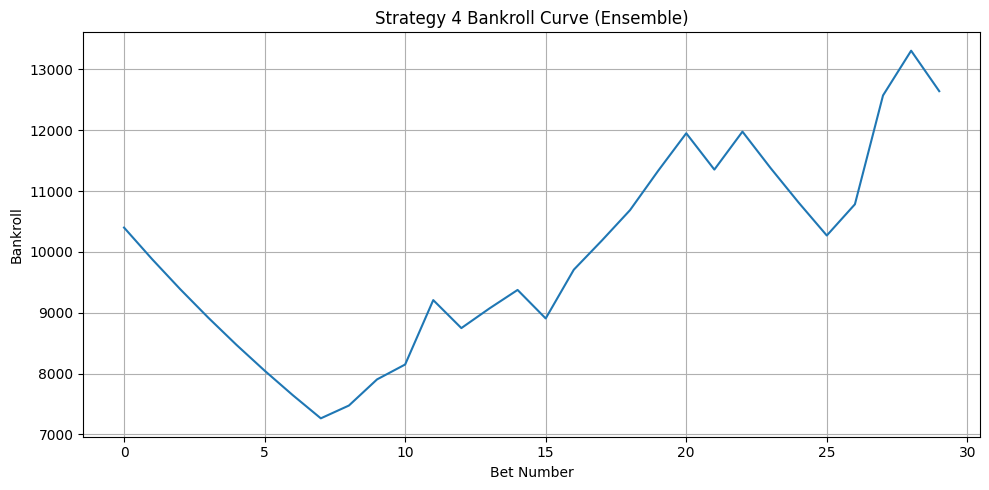

Saved audit CSV: strategy4_audit.csv
Saved bankroll plot: strategy4_bankroll_curve.png


In [60]:
EDGE_THRESHOLD = 0.14
KELLY_CAP = 0.05                   # max kelly per bet
ABS_STAKE_CAP = 0.10               # max stake = 10% bankroll
INITIAL_BANKROLL = 10000.0

EDGE_WEIGHT_ML = 0.5
EDGE_WEIGHT_POISSON = 0.25
EDGE_WEIGHT_ELO = 0.25

PLOT_FILENAME = "strategy4_bankroll_curve.png"
AUDIT_CSV = "strategy4_audit.csv"

#BASIC CHECKS

required_probs = {"p_H","p_D","p_A"}
if not required_probs.issubset(test_df.columns):
    raise RuntimeError("test_df must contain p_H, p_D, p_A. Attach model probabilities first.")

# 2) BEST ODDS GENERATION (safe & automated)

def best_series(df, cols):
    if not cols:
        return pd.Series([np.nan]*len(df))
    return df[cols].astype(float).max(axis=1, skipna=True)

all_cols = list(test_df.columns)

home_cands = [c for c in all_cols if c.upper().endswith("H") and c not in ["FTHG","HTHG"]]
draw_cands = [c for c in all_cols if c.upper().endswith("D")]
away_cands = [c for c in all_cols if c.upper().endswith("A") and c not in ["FTAG","HTAG"]]

test_df["odds_home_best"] = best_series(test_df, home_cands)
test_df["odds_draw_best"] = best_series(test_df, draw_cands)
test_df["odds_away_best"] = best_series(test_df, away_cands)

# 3) IMPLIED PROBABILITIES (remove overround)

for col, imp in [
    ("odds_home_best","imp_h"),
    ("odds_draw_best","imp_d"),
    ("odds_away_best","imp_a")
]:
    test_df[imp] = 1.0 / test_df[col]

test_df[["imp_h","imp_d","imp_a"]] = test_df[["imp_h","imp_d","imp_a"]].replace(
    [np.inf,-np.inf,0], np.nan
)

sum_imp = (
    test_df["imp_h"].fillna(0)
  + test_df["imp_d"].fillna(0)
  + test_df["imp_a"].fillna(0)
)

sum_imp = sum_imp.replace(0, np.nan)

test_df["imp_h"] = (test_df["imp_h"] / sum_imp).fillna(test_df["imp_h"].median())
test_df["imp_d"] = (test_df["imp_d"] / sum_imp).fillna(test_df["imp_d"].median())
test_df["imp_a"] = (test_df["imp_a"] / sum_imp).fillna(test_df["imp_a"].median())

# 4) POISSON & ELO SAFE FALLBACKS

if not {"pois_H","pois_D","pois_A"}.issubset(test_df.columns):
    print(" Poisson missing — using fallback 0s.")
    test_df["pois_H"] = 0.0
    test_df["pois_D"] = 0.0
    test_df["pois_A"] = 0.0

if "elo_diff_norm" not in test_df.columns:
    print(" Elo missing — using fallback.")
    test_df["elo_diff_norm"] = 0.0

# 5) BUILD ENSEMBLE EDGE


# ML edges
test_df["edge_ML_H"] = test_df["p_H"] - test_df["imp_h"]
test_df["edge_ML_D"] = test_df["p_D"] - test_df["imp_d"]
test_df["edge_ML_A"] = test_df["p_A"] - test_df["imp_a"]

# Poisson edges
test_df["edge_P_H"] = test_df["pois_H"] - test_df["imp_h"]
test_df["edge_P_D"] = test_df["pois_D"] - test_df["imp_d"]
test_df["edge_P_A"] = test_df["pois_A"] - test_df["imp_a"]

# Elo signal → convert to [-0.5, +0.5]
test_df["elo_signal"] = test_df["elo_diff_norm"] - 0.5

# Ensemble edges
test_df["ens_edge_H"] = (
    EDGE_WEIGHT_ML * test_df["edge_ML_H"] +
    EDGE_WEIGHT_POISSON * test_df["edge_P_H"] +
    EDGE_WEIGHT_ELO * test_df["elo_signal"]
)

test_df["ens_edge_D"] = (
    EDGE_WEIGHT_ML * test_df["edge_ML_D"] +
    EDGE_WEIGHT_POISSON * test_df["edge_P_D"]
)

test_df["ens_edge_A"] = (
    EDGE_WEIGHT_ML * test_df["edge_ML_A"] +
    EDGE_WEIGHT_POISSON * test_df["edge_P_A"] +
    EDGE_WEIGHT_ELO * (-test_df["elo_signal"])
)

test_df["best_edge_ens"] = test_df[["ens_edge_H","ens_edge_D","ens_edge_A"]].max(axis=1)
test_df["best_side_ens"] = test_df[["ens_edge_H","ens_edge_D","ens_edge_A"]].idxmax(axis=1).str[-1]

# 6) FINAL BACKTEST

bankroll = INITIAL_BANKROLL
records = []

for idx, r in test_df.iterrows():

    if r["best_edge_ens"] < EDGE_THRESHOLD:
        continue

    side = r["best_side_ens"]
    if side == "D":
        continue

    if side == "H":
        odds_exec = r["odds_home_best"]
        p = r["p_H"]
    else:
        odds_exec = r["odds_away_best"]
        p = r["p_A"]

    if pd.isna(odds_exec) or odds_exec < 1.01:
        continue

    # Kelly
    b = odds_exec - 1
    q = 1 - p
    f_raw = (b*p - q) / b if b > 0 else 0
    f = max(0, min(f_raw, KELLY_CAP, ABS_STAKE_CAP))

    stake = bankroll * f
    if stake <= 0:
        continue

    actual = r.get("result", r.get("FTR"))
    win = (actual == side)
    profit = stake*(odds_exec - 1) if win else -stake
    bankroll += profit

    records.append({
        "idx": idx,
        "date": r.get("Date"),
        "home": r.get("HomeTeam"),
        "away": r.get("AwayTeam"),
        "side": side,
        "prob": p,
        "odds": odds_exec,
        "stake": stake,
        "profit": profit,
        "bankroll": bankroll
    })


audit = pd.DataFrame(records)

print("========== STRATEGY 4 RESULTS ==========")
print("Bets placed:", len(audit))
print("Wins:", (audit["profit"] > 0).sum(),
      " | Loss:", (audit["profit"] < 0).sum())
print("Net profit:", bankroll - INITIAL_BANKROLL)
print("Final bankroll:", bankroll)

# 7) BANKROLL CURVE — SAFE, ERROR-FREE

audit["cum_bankroll"] = audit["bankroll"]

plt.figure(figsize=(10,5))
plt.plot(range(len(audit)), audit["cum_bankroll"])
plt.title("Strategy 4 Bankroll Curve (Ensemble)")
plt.xlabel("Bet Number")
plt.ylabel("Bankroll")
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOT_FILENAME)
plt.show()

# Save audit file
audit.to_csv(AUDIT_CSV, index=False)
print("Saved audit CSV:", AUDIT_CSV)
print("Saved bankroll plot:", PLOT_FILENAME)